# Global search using Lookup Table
## Synthetic model with 2 layers

In [1]:
%matplotlib widget

In [2]:
# Import libraries
import empymod
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
from scipy.constants import mu_0
import pandas as pd
import time

import sys
sys.path.insert(1, '../../src')

from PlotModel import PlotModelCond_2lay, Plot3Models_2lay, PlotErrorSpace, PlotData, rmse_a
from EM1D import EMforward2lay, GlobalSearch, ErrorSpace

In [3]:
def rse(targ, pred):
    return np.sqrt(((pred - targ)**2/targ**2))

def error(targ, pred):
    return (pred - targ)/targ

### 1. Define the synthetic model

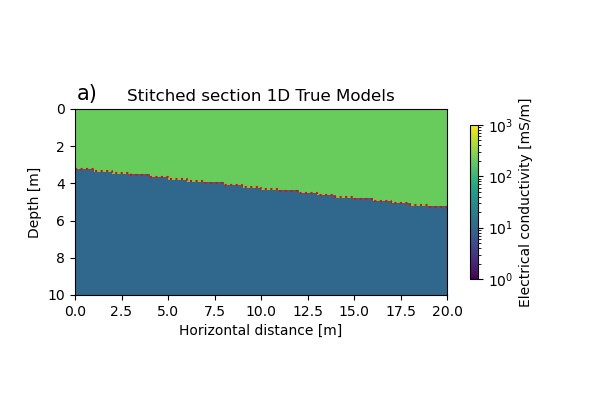

In [4]:
# Import the conductivities and thicknesses used to create the LU table

conds = np.load('../data/conds_samples.npy')
thick = np.load('../data/thick_samples.npy')

# parameters for the synthetic model

nlayer = 2 # number of layer
npos = 20 # number of sampling positions

sig_ini = [200/1000, 10/1000] # conductivities of the layers
sigmas = np.ones((npos, nlayer))*sig_ini # conductivity array

x = np.linspace(0, 20, npos) # Horizontal positions array
thk1 = 3 + x/10 +.25
#thk1 = np.ones_like(x)*4 + np.sin(2*np.pi*x)   # wave boundary for the layers
#thk1[10:] -= 2.5

depths = np.zeros((npos, nlayer))
depths[:,1] = thk1 

model_true_grid = PlotModelCond_2lay(sigmas, depths, depths)
plt.title('Stitched section 1D True Models')
plt.text(0.1,-0.5,'a)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
#plt.savefig('../figures/TrueModel_2Lay_flip')

### 2. Create synthetic data to test the global search

In [5]:
# Create empty array for true model in each position
model = np.stack((sigmas[:,0], sigmas[:,1], depths[:,1]), axis=1)

# Create empty array for true data in each position
data_true=[]

# Simulate data in each position
for i in range(npos):
    data_true.append(EMforward2lay(sigmas[i][0], sigmas[i][1], depths[i][1], height = 0.10)) 
    
data_true = np.array(data_true)

In [ ]:
np.save('../data/data_true_w_f', data_true)
np.save('../data/model_true_w_f', model)
np.save('../data/model_true_w_grid_f', model_true_grid)

### 3. Normalize data sets due to offset

In [6]:
LUT = np.load('../data/LookupTable2Layers.npy')

#norm = np.array([4, 2, 1])

#LUT_norm = LUT[:] * np.hstack([norm, norm, norm, norm, norm, norm])
#data_true_norm = data_true[:] * np.hstack([norm, norm, norm, norm, norm, norm])

### 3. Perform global search in each position

In [7]:
model_est = np.zeros_like(model)
model_est_Q = np.zeros_like(model)
model_est_IP = np.zeros_like(model)

#LUT_norm_slice = LUT_norm[:,:15].copy()
#LUT_norm_slice[:,:9] = LUT_norm[:,:9]
#LUT_norm_slice[:,9:] = LUT_norm[:,12:]

#data_true_norm_slice = data_true_norm[:,:15].copy()
#data_true_norm_slice[:,9:] = data_true_norm[:,12:]

# Estimate with both Quadrature and In Phase

starttime = time.time()

for p in range(npos):
    #model_est[p] = GlobalSearch(LUT_norm, data_true_norm, conds, thick)
    model_est[p] = GlobalSearch(LUT, data_true[p], conds, thick)

endtime = time.time() - starttime

print(endtime)

42.891711473464966


In [8]:
# Estimate using only Quadrature
for p in range(npos):
    #model_est_Q[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm[p,:9], conds, thick)
    model_est_Q[p] = GlobalSearch(LUT[:,:9], data_true[p,:9], conds, thick)
    
# Estimate using only In Phase
for p in range(npos):
    #model_est_IP[p] = GlobalSearch(LUT_norm[:,9:], data_true_norm[p,9:], conds, thick)
    model_est_IP[p] = GlobalSearch(LUT[:,9:], data_true[p,9:], conds, thick)

In [ ]:
np.save('../data/model_est_w_f', model_est)
np.save('../data/model_est_Q_w_f', model_est_Q)
np.save('../data/model_est_IP_w_f', model_est_IP)

### 4. Plot Estimated model

In [ ]:
#Plot3Models_2lay(model, model_est, model_est_Q, conds)
#plt.show()

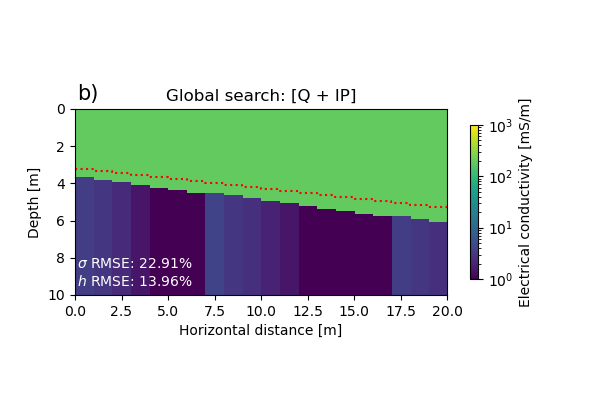

In [9]:
sigmas_est = model_est[:,:2]
depths_est = depths.copy()
depths_est[:,1] = model_est[:,2]

sigmas_est_Q = model_est_Q[:,:2]
depths_est_Q = depths.copy()
depths_est_Q[:,1] = model_est_Q[:,2]

sigmas_est_IP = model_est_IP[:,:2]
depths_est_IP = depths.copy()
depths_est_IP[:,1] = model_est_IP[:,2]

model_est_grid = PlotModelCond_2lay(sigmas_est, depths_est, depth_true=depths)
plt.title('Global search: [Q + IP]')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'b)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
#plt.savefig('../figures/GS_EstModel_Q+IP_2Lay_flip')


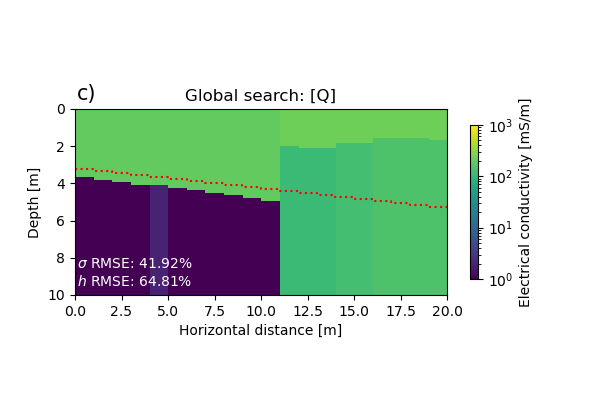

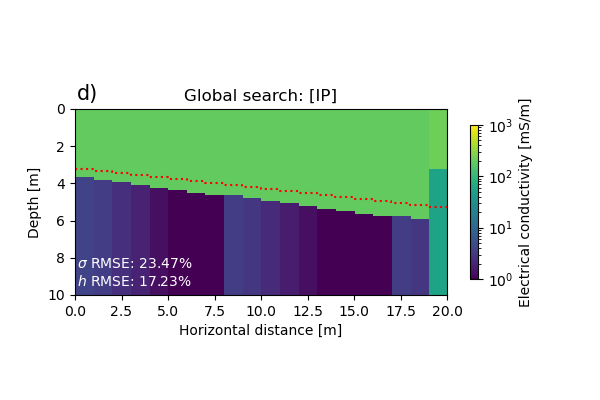

In [10]:
model_est_Q_grid = PlotModelCond_2lay(sigmas_est_Q, depths_est_Q, depth_true =depths)
plt.title('Global search: [Q]')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_Q)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_Q[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'c)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
#plt.savefig('../figures/GS_EstModel_Q_2Lay_flip')

model_est_IP_grid = PlotModelCond_2lay(sigmas_est_IP, depths_est_IP, depth_true=depths)
plt.title('Global search: [IP]')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_IP)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_IP[:,1])*100)+'%', color='w',fontsize=10)
plt.text(0.1,-0.5,'d)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
#plt.savefig('../figures/GS_EstModel_IP_2Lay_flip')

Text(0, 0.5, 'Depth [m]')

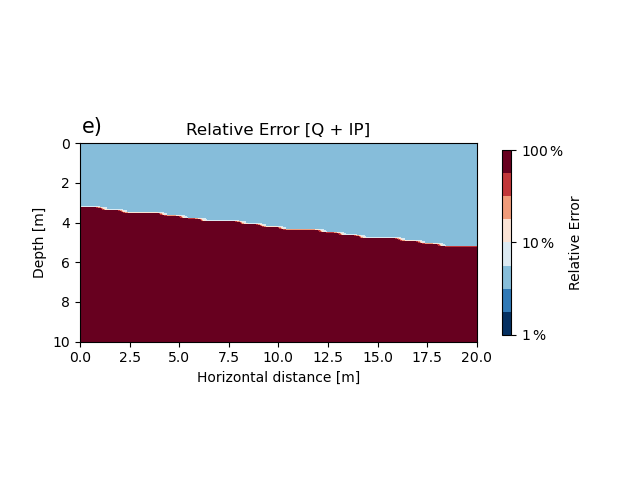

In [11]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid)/model_true_grid)*100
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [Q + IP]')
plt.text(0.1,-0.5,'e)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')

Text(0, 0.5, 'Depth [m]')

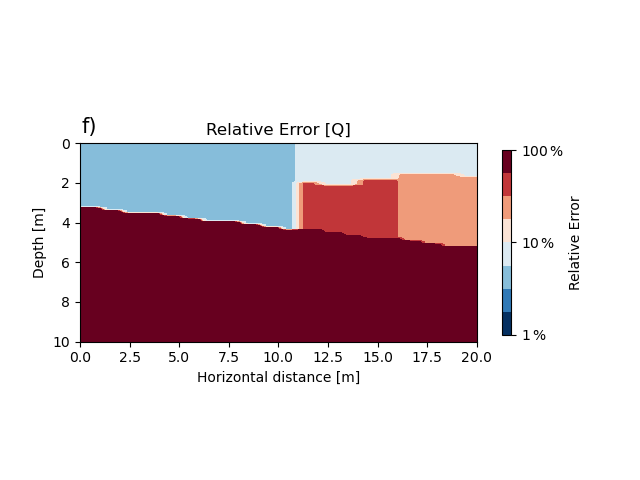

In [12]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_Q_grid)/model_true_grid)*100
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r",8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([ 0, 1, 2])
cbar.ax.set_yticklabels([  r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [Q]')
plt.text(0.1,-0.5,'f)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')

Text(0, 0.5, 'Depth [m]')

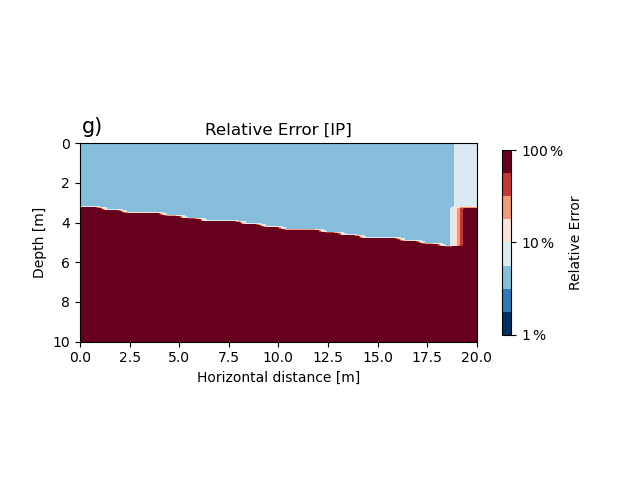

In [13]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_IP_grid)/model_true_grid)*100
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([ 0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [IP]')
plt.text(0.1,-0.5,'g)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')

### 5. Check the error space in a specific position

In [14]:
# For example let's check the following position
pos = 10

# Simulate data for this position
data_est_pos = EMforward2lay(model_est[pos,0], model_est[pos,1], model_est[pos,2], height=0.1)
#data_est_pos_norm = data_est_pos * np.hstack([norm, norm, norm, norm, norm, norm])

data_estQ_pos = EMforward2lay(model_est_Q[pos,0], model_est_Q[pos,1], model_est_Q[pos,2], height=0.1)
#data_estQ_pos_norm = data_estQ_pos * np.hstack([norm, norm, norm, norm, norm, norm])

data_estIP_pos = EMforward2lay(model_est_IP[pos,0], model_est_IP[pos,1], model_est_IP[pos,2], height=0.1)
#data_estIP_pos_norm = data_estIP_pos * np.hstack([norm, norm, norm, norm, norm, norm])

# Evaluate error space
#err, models_err = ErrorSpace(LUT_norm, data_est_pos_norm, 0.1, conds, thick)
#err_Q, models_err_Q = ErrorSpace(LUT_norm, data_estQ_pos_norm, 0.1, conds, thick)
#err_IP, models_err_IP = ErrorSpace(LUT_norm, data_estIP_pos_norm, 0.1, conds, thick)
err, models_err = ErrorSpace(LUT, data_est_pos, 0.1, conds, thick)
#err_Q, models_err_Q = ErrorSpace(LUT, data_estQ_pos, 0.11, conds, thick)
#err_IP, models_err_IP = ErrorSpace(LUT, data_estIP_pos, 0.11, conds, thick)

Text(0.5, 0, 'Depth [m]')

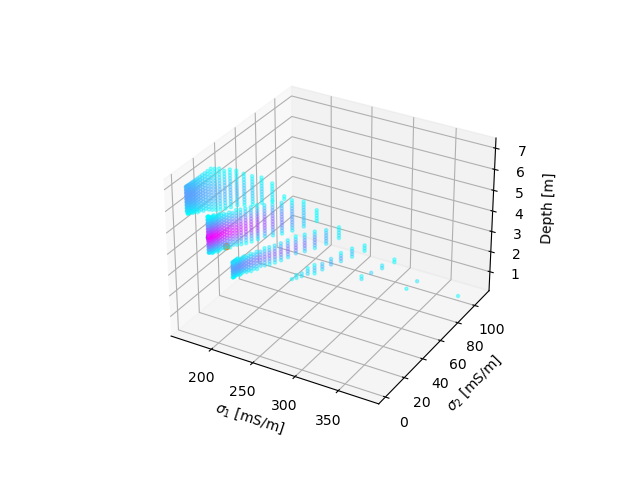

In [15]:
conds1_b1 = models_err[:,0]
conds2_b1 = models_err[:,1]
thicks_b1 = models_err[:,2]

fig = plt.figure()

ax3D = fig.add_subplot(111, projection='3d')
p = ax3D.scatter(((conds1_b1)*1000), ((conds2_b1)*1000), thicks_b1,
                 s=5, c=err, marker='o', cmap='cool_r', alpha=0.4)
ax3D.scatter(model_est[pos,0]*1000, model_est[pos,1]*1000, model_est[pos,2])
ax3D.scatter(model[pos,0]*1000, model[pos,1]*1000, model[pos,2])
ax3D.set_xlabel('$\sigma_1$ [mS/m]')
ax3D.set_ylabel('$\sigma_2$ [mS/m]')
ax3D.set_zlabel('Depth [m]')

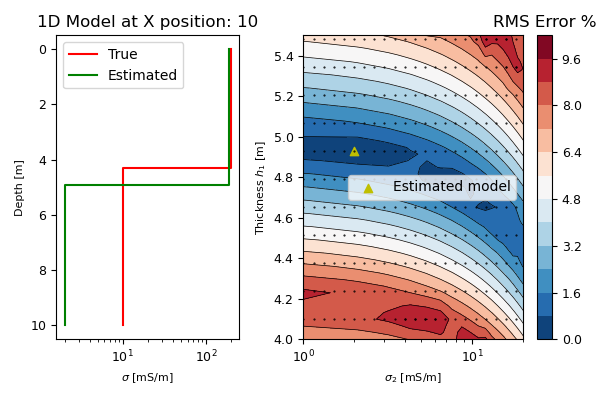

In [26]:
# Error space using Q + IP
import matplotlib.tri as tri

def PlotErrorSpace(model, model_est, pos, err, models_err, depthmax=10):
    
    # Arrays to plot
    depth_true = np.array([0, model[pos,2], depthmax])
    depth_est = np.array([0, model_est[pos,2], depthmax])

    sigma_true = np.hstack([model[pos,:2], model[pos,1]])
    sigma_est = np.hstack([model_est[pos,:2], model_est[pos,1]])
       
    fig, ax = plt.subplots(1,2, figsize=(6,4), gridspec_kw={'width_ratios': [1,1.5]})
    
    ax[0].step(sigma_true*1000, depth_true, 'r', label = 'True')
    ax[0].step(sigma_est*1000, depth_est, 'g', label='Estimated')
    ax[0].invert_yaxis()
    ax[0].set_ylabel('Depth [m]', fontsize=8)
    ax[0].set_xlabel('$\sigma$ [mS/m]', fontsize=8)
    ax[0].set_title('1D Model at X position: ' +str(pos))
    ax[0].set_xscale('log')
    ax[0].legend()

    x = ((models_err[:,1])*1000) # conductivities of second layer
    y = models_err[:,2]                  # thickness of first layer
    z = err

    ngridx = 100
    ngridy = 200
    
    # Create grid values first.
    xi = np.linspace(np.min(x), np.max(x), ngridx)
    yi = np.linspace(np.min(y), np.max(y), ngridy)

    # Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
    triang = tri.Triangulation(x, y)
    interpolator = tri.LinearTriInterpolator(triang, z)
    Xi, Yi = np.meshgrid(xi, yi)
    zi = interpolator(Xi, Yi)
    
    # Note that scipy.interpolate provides means to interpolate data on a grid
    # as well. The following would be an alternative to the four lines above:
    # from scipy.interpolate import griddata
    # zi = griddata((x, y), z, (xi[None, :], yi[:, None]), method='linear')

    ax[1].contour(xi, yi, zi*100, levels=14, linewidths=0.5, colors='k')
    cntr1 = ax[1].contourf(xi, yi, zi*100, levels=14, cmap="RdBu_r")
    ax[1].plot(x, y, '.k', ms=1)
    ax[1].set(xlim=(1,20), ylim=(4,5.5))
    ax[1].scatter(((model_est[pos,1])*1000), model_est[pos,2],
                 marker ='^', c='y', label='Estimated model')
    #ax1.scatter( np.log10((model_cm_pos[1])*1000), model_cm_pos[2],
    #             marker ='^', c='k', label='Closest')
    ax[1].set_xlabel('$\sigma_2$ [mS/m]', fontsize=8)
    ax[1].set_ylabel('Thickness $h_1$ [m]', fontsize=8)
    ax[1].set_xscale('log')
    ax[1].legend()
    ax[1].tick_params(axis='both',labelsize=9)
    ax[0].tick_params(axis='both',labelsize=9)
    clb = fig.colorbar(cntr1, ax=ax[1])
    clb.ax.set_title('RMS Error %')
    clb.ax.tick_params(labelsize=9)

PlotErrorSpace(model, model_est, pos, err, models_err)
plt.tight_layout()
plt.show()
#plt.savefig('../figures/error_space')

## Noise examples

In [ ]:
## Let's test the Global search with noise added to data

# Adding noise to data
error = 0.1

data_true_noise_Q = data_true[:,:9].copy()
data_true_noise_IP = data_true[:,9:].copy()

data_true_noise_Q *= np.random.randn(np.size(data_true_noise_Q)).reshape(np.shape(data_true_noise_Q))*error+1
data_true_noise_IP *= np.random.randn(np.size(data_true_noise_IP)).reshape(np.shape(data_true_noise_IP))*error+1
#data_true_noise *= np.random.normal(0.0, 0.04, size=np.shape(data_true))+1
#data_true_noise *= np.random.randn(np.size(data_true)).reshape(np.shape(data_true))*error+1

In [ ]:
fig, ax = plt.subplots(3,2)

ax[0,0].plot(data_true_noise_Q[:,0])
ax[0,0].plot(data_true[:,0], '.')
ax[0,0].plot(data_true_noise_Q[:,3])
ax[0,0].plot(data_true[:,3], '.')
ax[0,0].plot(data_true_noise_Q[:,6])
ax[0,0].plot(data_true[:,6], '.')

ax[1,0].plot(data_true_noise_Q[:,1])
ax[1,0].plot(data_true[:,1], '.')
ax[1,0].plot(data_true_noise_Q[:,4])
ax[1,0].plot(data_true[:,4], '.')
ax[1,0].plot(data_true_noise_Q[:,7])
ax[1,0].plot(data_true[:,7], '.')

ax[2,0].plot(data_true_noise_Q[:,2])
ax[2,0].plot(data_true[:,2], '.')
ax[2,0].plot(data_true_noise_Q[:,5])
ax[2,0].plot(data_true[:,5], '.')
ax[2,0].plot(data_true_noise_Q[:,8])
ax[2,0].plot(data_true[:,8], '.')

ax[0,1].plot(data_true_noise_IP[:,0])
ax[0,1].plot(data_true[:,9], '.')
ax[0,1].plot(data_true_noise_IP[:,3])
ax[0,1].plot(data_true[:,12], '.')
ax[0,1].plot(data_true_noise_IP[:,6])
ax[0,1].plot(data_true[:,15], '.')

ax[1,1].plot(data_true_noise_IP[:,1])
ax[1,1].plot(data_true[:,10], '.')
ax[1,1].plot(data_true_noise_IP[:,4])
ax[1,1].plot(data_true[:,13], '.')
ax[1,1].plot(data_true_noise_IP[:,7])
ax[1,1].plot(data_true[:,16], '.')

ax[2,1].plot(data_true_noise_IP[:,2])
ax[2,1].plot(data_true[:,11], '.')
ax[2,1].plot(data_true_noise_IP[:,5])
ax[2,1].plot(data_true[:,14], '.')
ax[2,1].plot(data_true_noise_IP[:,8])
ax[2,1].plot(data_true[:,17], '.')

In [ ]:
data_true_noise = data_true.copy()
data_true_noise[:,:9] = data_true_noise_Q
data_true_noise[:,9:] = data_true_noise_IP

np.save('../data/data_true_noise10_w_f', data_true_noise)

In [ ]:
fig, ax = plt.subplots(3,2, sharex=True)
PlotData(data_true, ax=ax)
#PlotData(data_true_noise, ax=ax)
fig.suptitle('Not normalized')
plt.tight_layout()

In [ ]:
#data_true_norm_noise = data_true_noise[:] * np.hstack([norm, norm, norm, norm, norm, norm])

model_est_noise = model.copy()
model_est_Q_noise = model.copy()
model_est_IP_noise = model.copy()

#LUT_norm_slice = LUT_norm[:,:15].copy()
#LUT_norm_slice[:,:9] = LUT_norm[:,:9]
#LUT_norm_slice[:,9:] = LUT_norm[:,12:]

#data_true_norm_noise_slice = data_true_norm_noise[:,:15].copy()
#data_true_norm_noise_slice[:,9:] = data_true_norm_noise[:,12:]

# Estimate with both Quadrature and In Phase
for p in range(npos):
    #model_est_noise[p] = GlobalSearch(LUT_norm_slice, data_true_norm_noise_slice[p], conds, thick)
    model_est_noise[p] = GlobalSearch(LUT, data_true_noise[p], conds, thick)
    
# Estimate using only Quadrature
#for p in range(npos):
    #model_est_Q_noise[p] = GlobalSearch(LUT_norm[:,:9], data_true_norm_noise[p,:9], conds, thick)
    #model_est_Q_noise[p] = GlobalSearch(LUT[:,:9], data_true_noise_Q[p,:], conds, thick)
    
# Estimate using only Quadrature
#for p in range(npos):
    #model_est_IP_noise[p] = GlobalSearch(LUT_norm[:,9:], data_true_norm_noise[p,9:], conds, thick)
    #model_est_IP_noise[p] = GlobalSearch(LUT[:,9:], data_true_noise_IP[p,:], conds, thick)

In [ ]:
#fig, ax = plt.subplots(3,2, sharex=True)
#PlotData(data_true_norm, ax=ax)
#PlotData(data_true_norm_noise, ax=ax)
#fig.suptitle('Normalized')
#plt.tight_layout()

In [ ]:
np.save('../data/model_est_noise10_w_f', model_est_noise)
#np.save('../data/model_est_Q_noise2_w', model_est_Q_noise)
#np.save('../data/model_est_IP_noise2_w', model_est_IP_noise)

In [ ]:
#Plot3Models_2lay(model, model_est_noise, model_est_Q_noise, conds)
#plt.show()

In [ ]:
sigmas_est_noise = model_est_noise[:,:2]
depths_est_noise = depths.copy()
depths_est_noise[:,1] = model_est_noise[:,2]

model_est_grid_n = PlotModelCond_2lay(sigmas_est_noise, depths_est_noise, depths)
plt.title('Global search: [Q + IP], noise = 10%')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_noise)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_noise[:,1])*100)+'%', color='w',
         fontsize=10)
plt.text(0.1,-0.5,'c)', color='k',fontsize=15)
plt.show()
plt.tight_layout()
#plt.savefig('../figures/GS_EstModel_Q+IP_2Lay_noise10_flip')



In [ ]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid_n)/model_true_grid)*100
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([ 0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])
plt.title('Relative Error [Q + IP], noise: 10%')
plt.text(0.1,-0.5,'f)', color='k',fontsize=15)
plt.xlabel('Horizontal distance [m]')
plt.ylabel('Depth [m]')

In [ ]:
sigmas_est_Q_noise = model_est_Q_noise[:,:2]
depths_est_Q_noise = depths.copy()
depths_est_Q_noise[:,1] = model_est_Q_noise[:,2]

sigmas_est_IP_noise = model_est_IP_noise[:,:2]
depths_est_IP_noise = depths.copy()
depths_est_IP_noise[:,1] = model_est_IP_noise[:,2]

model_est_grid_Q_n = PlotModelCond_2lay(sigmas_est_Q_noise, depths_est_Q_noise, depths)
plt.title('Global search: [Q], noise = 2.5%')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_Q_noise)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_Q_noise[:,1])*100)+'%', color='w',fontsize=10)
plt.show()

model_est_grid_IP_n = PlotModelCond_2lay(sigmas_est_IP_noise, depths_est_IP, depths)
plt.title('Global search: [IP], noise = 2.5%')
plt.text(0.1,9.5,'$\sigma$ RMSE: %2.2f' %(rmse_a(np.log10(np.hstack(sigmas)),
                np.log10(np.hstack(sigmas_est_IP_noise)))*100)+ '% \n' +
                '$h$ RMSE: %2.2f' %(rmse_a(depths[:,1], depths_est_IP_noise[:,1])*100)+'%', color='w',fontsize=10)
plt.show()

In [ ]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid_Q_n)/model_true_grid)*100
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([ 0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])

In [ ]:
fig, ax = plt.subplots()

error_est = np.abs((model_true_grid-model_est_grid_IP_n)/model_true_grid)*100
cf = ax.imshow(np.log10(error_est).T, extent=[0,npos,10,0], vmin=0, vmax=2,
          cmap=plt.cm.get_cmap("RdBu_r", 8))
cbar = fig.colorbar(cf, ax=ax, label=r"Relative Error",  shrink=0.5)
cbar.set_ticks([ 0, 1, 2])
cbar.ax.set_yticklabels([ r"$1\,\%$",
                         r"$10\,\%$", r"$100\,\%$"])

In [ ]:
data_noise2 = np.load('../data/data_true_noise2_w.npy')
data_noise5 = np.load('../data/data_true_noise5_w.npy')
data_noise10 = np.load('../data/data_true_noise10_w.npy')
data_true = np.load('../data/data_true_w.npy')


In [ ]:
fig, ax = plt.subplots(3,2, sharex=True, figsize=(6,4))
PlotData(data_true, ax=ax)
PlotData(data_noise2, ax=ax, style=':', lab='Noise 2.5%')
PlotData(data_noise5, ax=ax, style='--', lab='Noise 5%')
PlotData(data_noise10, ax=ax, style='-*', lab= 'Noise 10%')
plt.tight_layout()
plt.savefig('Data_noise')

### Figure cummulative sensitivity

In [ ]:
from EM1D import R_HCP, R_VCP, R_PRP

In [ ]:
# z represents depth/sep normalized depth

z = np.linspace(0,10,100)
s1 = 2
s2 = 4
s3 = 8
s11 = 2.1
s21 = 4.1
s31 = 8.1

CumSensH2 = R_HCP(z/s1)
CumSensH4 = R_HCP(z/s2)
CumSensH8 = R_HCP(z/s3)

CumSensV2 = R_VCP(z/s1)
CumSensV4 = R_VCP(z/s2)
CumSensV8 = R_VCP(z/s3)

CumSensP2 = R_PRP(z/s11)
CumSensP4 = R_PRP(z/s21)
CumSensP8 = R_PRP(z/s31)

In [ ]:
fig, ax = plt.subplots()

ax.plot(CumSensH2,z, 'b', label='H2')
ax.plot(CumSensH4,z, ':b', label='H4')
ax.plot(CumSensH8,z, '--b', label='H8')

ax.plot(CumSensV2,z, 'g', label='V2')
ax.plot(CumSensV4,z, ':g', label='V4')
ax.plot(CumSensV8,z, '--g', label='V8')

ax.plot(CumSensP2,z, 'r', label='P2.1')
ax.plot(CumSensP4,z, ':r', label='P4.1')
ax.plot(CumSensP8,z, '--r', label='P8.1')

ax.invert_yaxis()
ax.set_ylabel('Depth [m]')
ax.set_xlabel('Cummulative Sensitivity')
ax.legend()